In [17]:
!pip install wordcloud
!pip install nltk spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
#Импортируем все необходимые библиотеки
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
import nltk
import spacy
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#Загрузим датафрейм из файла
df = pd.read_csv('/content/fake_news.csv')

In [3]:
#Получим кол-во новостей каждого типа и отобразим сравнение на графике
i = df.label.value_counts()

In [4]:
fig = go.Figure(data=[go.Bar(
            x=['Real','Fake'], y=i,
            text=i,
            textposition='auto',
        )])

fig.show()
#Как можно увидеть, датасет содержит примерно одиноковое кол-во и реальных и фейковых новостей

In [6]:
#Разделим исходный датафрейм на 2 для упрощения визуализации ключевых слов
real_df = df[df['label'] == 'REAL']
fake_df = df[df['label'] == 'FAKE']

(3164, 4)

In [11]:
#Подготавливаем текст, очищая его от лишних символов и приводя слова к единому значению

nlp = spacy.load('en_core_web_sm')  # Для лемматизации

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



In [13]:
# Функция для очистки текста
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Функция для лемматизации текста
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [14]:
real_df['text'].apply(clean_text)
real_df['text'].apply(lemmatize_text)

fake_df['text'].apply(clean_text)
fake_df['text'].apply(lemmatize_text)

,text
0,"Daniel Greenfield , a Shillman Journalism Fell..."
1,Google Pinterest Digg Linkedin Reddit Stumbleu...
3,"— Kaydee King ( @KaydeeKing ) November 9 , 201..."
5,"\n I ’m not an immigrant , but my grandparen..."
6,"share this Baylee Luciani ( leave ) , Screensh..."
...,...
6326,DOJ COMPLAINT : Comey under Fire Over Partisan...
6328,
6329,Julian Assange have claim the Hillary Clinton ...
6331,the ' p ' in PBS should stand for ' plutocrati...


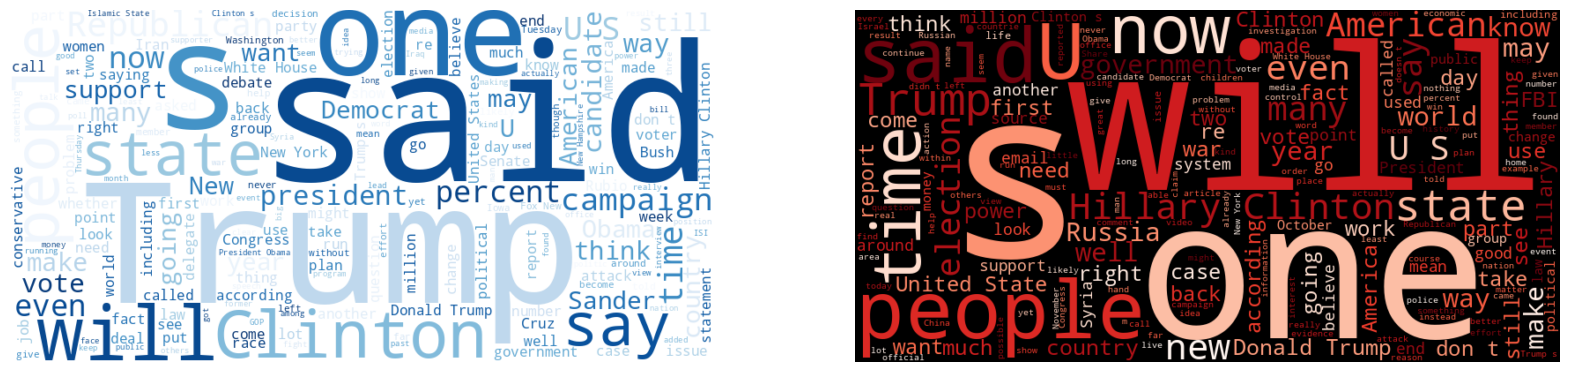

In [15]:
#Отобразим ключевые слова из 2 датафреймов

text_data_real = " ".join(text for text in real_df['text'])
text_data_fake = " ".join(text for text in fake_df['text'])

# Настройка облака слов
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text_data_real)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(text_data_fake)

# Выведем картинки сгенерированные вордклаудом
fig, ax = plt.subplots(1, 2, figsize = (20, 12))

ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].axis("off")
ax[1].axis("off")

plt.show()

In [16]:
#Разбиваем данные на обучающие и тестовые
X_train,X_test,y_train,y_test = train_test_split(df['text'], df.label, test_size=0.2, random_state=7)

In [17]:
# Получим векторные представления текстов
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

In [18]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [20]:
#Создаем модель с помощью PAC
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [21]:
#Проверяем модель на тестовых данных
y_pred = pac.predict(tfidf_test)

In [22]:
#Выводим точность предсказания модели
score = accuracy_score(y_test,y_pred)
print('Точность: %.2f%%' % (score * 100))

Точность: 92.66%


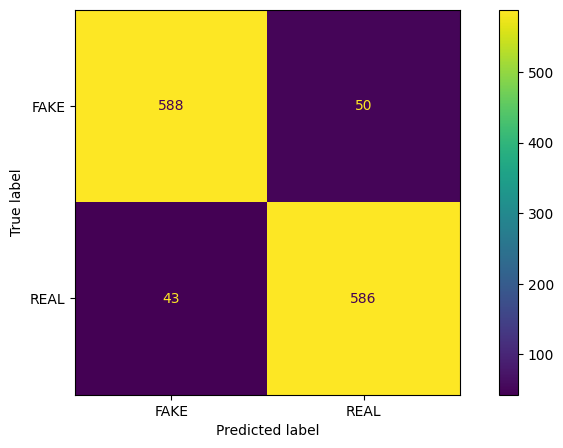

In [23]:
#Построим матрицу ошибок
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)

In [24]:
print('\n Clasification report:\n', classification_report(y_test,y_pred))


 Clasification report:
               precision    recall  f1-score   support

        FAKE       0.93      0.92      0.93       638
        REAL       0.92      0.93      0.93       629

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



In [25]:
#Проверим модель на произвольных данных не из датасета
ii=['This is a really important question, Lambert says. “I don’t want to be passed along to two or three people,” she says. “I want one person to contact.” There may be specific contact points for different areas, she adds, such as the director of nursing for related questions. However, “I want to know that I can pop into the executive director’s office anytime, ask any question and make any kind of complaint,” she emphasizes. “I want to know that person is available. Because sometimes, you have to go up to that level.""']

In [26]:
ii= tfidf_vectorizer.transform(ii)

In [27]:
y_pred=pac.predict(ii)

In [28]:
y_pred

array(['REAL'], dtype='<U4')